# Controlling Burgers' Equation with Reinforcement Learning

In the following, we will target inverse problems with Burgers equation as a testbed for reinforcement learning (RL). The setup is similar to the inverse problems previously targeted with differentiable physics (DP) training (cf. {doc}`diffphys-code-control`), and hence we'll also directly compare to these approaches below. Similar to before, Burgers equation is simple but non-linear with interesting dynamics, and hence a good starting point for RL experiments. In the following, the goal is to train a control force estimator network that should predict the forces needed to generate smooth transitions between two given states. 
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/reinflearn-code.ipynb)




## Overview

Reinforcement learning describes an agent perceiving an environment and taking actions inside it. It aims at maximizing an accumulated sum of rewards, which it receives for those actions by the environment. Thus, the agent learns empirically which actions to take in different situations. _Proximal policy optimization_ [(PPO)](https://arxiv.org/abs/1707.06347v2) is a widely used reinforcement learning algorithm describing two neural networks: a policy NN selecting actions for given observations and a value estimator network rating the reward potential of those states. These value estimates form the loss of the policy network, given by the change in reward potential by the chosen action.

This notebook illustrates how PPO reinforcement learning can be applied to the described control problem of Burgers' equation. In comparison to the DP approach, the RL method does not have access to a differentiable physics solver, it is _model-free_. 

However, the goal of the value estimator NN is to compensate for this lack of a solver, as it tries to capture the long term effect of individual actions. Thus, an interesting question the following code example should answer is: can the model-free PPO reinforcement learning match the performance of the model-based DP training. We will compare this in terms of learning speed and the amount of required forces.


## Setup

### If working online

In [1]:
# # This is to synchronize my Colab workspace with my local workspace.
# try:
#   from google.colab import drive
#   drive.mount('/content/gdrive', force_remount=True)

#   FOLDERNAME = 'Etudes/Ponts et Chaussees/Stages/2eme stage/Travail/Physics based DL/RL-Burgers-control/PDE-Control-RL'
#   %cd /content/gdrive/My\ Drive/$FOLDERNAME
# except ImportError:
#   pass

Mounted at /content/gdrive
/content/gdrive/My Drive/Etudes/Ponts et Chaussees/Stages/2eme stage/Travail/Physics based DL/RL-Burgers-control/PDE-Control-RL


In [2]:
# !pip install stable-baselines3==1.1 phiflow==1.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.6/172.6 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 42.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for phiflow: filename=phiflow-1.5.1-py3-none-any.whl size=2775295 sha256=8a4b1ff8b48dc4d367c47c76cefcb4a72ca523605de0cc2f5f21dd13c3eab361
  Stored in directory: /root/.cache/pip/wheels/8f/5d/1e/20e2b003205dc824c8d1ceb6e6b896f9c5de52c9049f41a163
Successfully built phiflow


### If working offline

tensorboard and imageio must be installed on the Python env.

In [ ]:
# This is to fix an error arising when calling "box"
import collections
collections.Iterable = collections.abc.Iterable

If calling `plt` makes the kernel restart, it might be due to the problem presented on the following link:
https://www.programmersought.com/article/53286415201/. 
The `libiomp5md.dll` file in the `Library/bin` folder of the `RL` conda environment folder has been backuped in `backup_TT` in the folder of this environment.

## Software installation

This example uses the reinforcement learning framework [stable_baselines3](https://github.com/DLR-RM/stable-baselines3) with [PPO](https://arxiv.org/abs/1707.06347v2) as reinforcement learning algorithm.
For the physical simulation, version 1.5.1 of the differentiable PDE solver [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow) is used. 

After the RL training is completed, we'll additionally compare it to a differentiable physics approach using a "control force estimator" (CFE) network from {doc}`diffphys-code-control` (as introduced by {cite}`holl2019pdecontrol`).

Now we can import the necessary modules. Due to the scope of this example, there are quite a few modules to load.

In [ ]:
import sys; sys.path.append('PDE-Control/src'); sys.path.append('src')
import time, csv, os, shutil
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from phi.flow import *
import burgers_plots as bplt
import matplotlib.pyplot as plt
from envs.burgers_util import GaussianClash, GaussianForce
# TT: Ignore the "No module named 'dash_core_components'. To install all dependencies, run $ pip install phiflow[gui]" warning if it occurs.

D:\Logiciels\Anaconda3\envs\RL\lib\site-packages\phi\viz\display.py:80: UserWarning: GUI is disabled because of missing dependencies: No module named 'dash_core_components'. To install all dependencies, run $ pip install phiflow[gui]
  warnings.warn('GUI is disabled because of missing dependencies: %s. To install all dependencies, run $ pip install phiflow[gui]' % import_error)


## Data generation

First we generate a dataset which we will use to train the differentiable physics model on. We'll also use it to evaluate the performance of both approaches during and after training. The code below simulates 1000 cases (i.e. phiflow "scenes"), and keeps 100 of them as validation and test cases, respectively. The remaining 800 are used for training.

In [ ]:
DOMAIN = Domain([32], box=box[0:1])     # Size and shape of the fields
VISCOSITY = 0.003
STEP_COUNT = 32                         # Trajectory length
DT = 0.03
DIFFUSION_SUBSTEPS = 1                  # ?

DATA_PATH = 'forced-burgers-clash'      # Folder where the resulting scenes are stored
SCENE_COUNT = 1000
BATCH_SIZE = 100                        # The size of batches by which the data is generated

TRAIN_RANGE = range(200, 1000)
VAL_RANGE = range(100, 200)
TEST_RANGE = range(0, 100)

In [ ]:
# # This cell generates training data. It should be run only once, because the training
# for batch_index in range(SCENE_COUNT // BATCH_SIZE):
#     scene = Scene.create(DATA_PATH, count=BATCH_SIZE)  # Instanciates batch_size scenes
#     print(scene)
#     world = World()
#     u0 = BurgersVelocity(
#         DOMAIN, 
#         velocity=GaussianClash(BATCH_SIZE),  # TT: Initialize the velocity as the sum of two gaussians (a left one and a right one) of opposite amplitudes
#         viscosity=VISCOSITY, 
#         batch_size=BATCH_SIZE, 
#         name='burgers'
#     )
#     u = world.add(u0, physics=Burgers(diffusion_substeps=DIFFUSION_SUBSTEPS))
#     force = world.add(FieldEffect(GaussianForce(BATCH_SIZE), ['velocity']))
#     scene.write(world.state, frame=0)
#     for frame in range(1, STEP_COUNT + 1):
#         world.step(dt=DT)
#         scene.write(world.state, frame=frame)

## Training via reinforcement learning

Next we set up the RL environment. The PPO approach uses a dedicated value estimator network (the "critic") to predict the sum of rewards generated from a certain state. These predicted rewards are then used to update a policy network (the "actor") which, analogously to the CFE network of {doc}`diffphys-code-control`, predicts the forces to control the simulation.

In [ ]:
from experiment import BurgersTraining

N_ENVS = 10                         # On how many environments to train in parallel, load balancing
FINAL_REWARD_FACTOR = STEP_COUNT    # Penalty for not reaching the goal state
STEPS_PER_ROLLOUT = STEP_COUNT * 10 # How many steps to collect per environment between agent updates
N_EPOCHS = 10                       # How many epochs to perform during each agent update
RL_LEARNING_RATE = 1e-4             # Learning rate for agent updates
RL_BATCH_SIZE = 128                 # Batch size for agent updates
RL_ROLLOUTS = 500                   # Number of iterations for RL training

To start training, we create a trainer object which manages the environment and the agent internally. Additionally, a directory for storing models, logs, and hyperparameters is created. This way, training can be continued at any later point using the same configuration. If the model folder specified in `exp_name` already exists, the agent within is loaded; otherwise, a new agent is created. For the PPO reinforcement learning algorithm, the implementation of `stable_baselines3` is used. The trainer class acts as a wrapper for this system. Under the hood, an instance of a `BurgersEnv` gym environment is created, which is loaded into the PPO algorithm. It generates random initial states, precomputes corresponding ground truth simulations and handles the system evolution influenced by the agent's actions. Furthermore, the trainer regularly evaluates the performance on the validation set by loading a different environment that uses the initial and target states of the validation set.




### Gym environment 

The gym environment specification provides an interface leveraging the interaction with the agent. Environments implementing it must specify observation and action spaces, which represent the in- and output spaces of the agent. Further, they have to define a set of methods, the most important ones being `reset`, `step`, and `render`. 

* `reset` is called after a trajectory has ended, to revert the environment to an initial state, and returns the corresponding observation. 
* `step` takes an action given by the agent and iterates the environment to the next state. It returns the resulting observation, the received reward, a flag determining whether a terminal state has been reached and a dictionary for debugging and logging information. 
* `render` is called to display the current environment state in a way the creator of the environment specifies. This function can be used to inspect the training results.

`stable-baselines3` expands on the default gym environment by providing an interface for vectorized environments. This makes it possible to compute the forward pass for multiple trajectories simultaneously which can in turn increase time efficiency because of better resource utilization. In practice, this means that the methods now work on vectors of observations, actions, rewards, terminal state flags and info dictionaries. The step method is split into `step_async` and `step_wait`, making it possible to run individual instances of the environment on different threads.

### Physics simulation 

The environment for Burgers' equation contains a `Burgers` physics object provided by `phiflow`. The states are internally stored as `BurgersVelocity` objects. To create the initial states, the environment generates batches of random fields in the same fashion as in the data set generation process shown above. The observation space consists of the velocity fields of the current and target states stacked in the channel dimension with another channel specifying the current time step. Actions are taken in the form of a one dimensional array covering every velocity value. The `step` method calls the physics object to advance the internal state by one time step, also applying the actions as a `FieldEffect`.

The rewards encompass a penalty equal to the square norm of the generated forces at every time step. Additionally, the $L^2$ distance to the target field, scaled by a predefined factor (`FINAL_REWARD_FACTOR`) is subtracted at the end of each trajectory. The rewards are then normalized with a running estimate for the reward mean and standard deviation.


### Neural network setup

We use two different neural network architectures for the actor and critic respectively. The former uses the U-Net variant from {cite}`holl2019pdecontrol`, while the latter consists of a series of 1D convolutional and pooling layers reducing the feature map size to one. The final operation is a convolution with kernel size one to combine the feature maps and retain one output value. The `CustomActorCriticPolicy` class then makes it possible to use these two separate network architectures for the reinforcement learning agent.

By default, an agent is stored at `PDE-Control-RL/networks/rl-models/bench`, and loaded if it exists. (If necessary, replace the `path` below with a new one to start with a new model.) As the training takes quite long, we're starting with a pre-trained agent here. It is already trained for 3500 iterations, and hence we're only doing a "fine-tuning" below with another `RL_ROLLOUTS=500` iterations. These typically take around 2 hours, and hence the total training time of almost 18 hours would be too long for interactive tests. (However, the code provided here contains everything to train a model from scratch if you have the resources.)

***NB (TT):*** the `data` file in `PDE-Control-RL/networks/rl-models/bench/agent.zip` has been modified; clip_range has been set to `0.2`. It was initially a `deque` object, making the code bug.

In [ ]:
rl_trainer = BurgersTraining(
    path='networks/rl-models/test', # Replace path to train a new model
    domain=DOMAIN,
    viscosity=VISCOSITY,
    step_count=STEP_COUNT,
    dt=DT,
    diffusion_substeps=DIFFUSION_SUBSTEPS,
    n_envs=N_ENVS,
    final_reward_factor=FINAL_REWARD_FACTOR,
    steps_per_rollout=STEPS_PER_ROLLOUT,
    n_epochs=N_EPOCHS,
    learning_rate=RL_LEARNING_RATE,
    batch_size=RL_BATCH_SIZE,
    data_path=DATA_PATH,
    val_range=VAL_RANGE,
    test_range=TEST_RANGE,
)

Tensorboard log path: networks/rl-models/test\tensorboard-log
Creating new agent...


The following cell is optional but very useful for debugging: it opens _tensorboard_ inside the notebook to display the progress of the training. If a new model was created at a different location, please change the path accordingly. When resuming the learning process of a pre-trained agent, the new run is shown separately in tensorboard (enable reload via the cogwheel button).

The graph titled "forces" shows how the overall amount of forces generated by the network evolves during training. "rew_unnormalized" shows the reward values without the normalization step described above. The corresponding values with normalization are shown under "rollout/ep_rew_mean". "val_set_forces" outlines the performance of the agent on the validation set.

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir networks/rl-models/bench/tensorboard-log

Now we are set up to start training the agent. The RL approach requires many iterations to explore the environment. Hence, the next cell typically takes multiple hours to execute (around 2h for 500 rollouts).

In [ ]:
# # rl_trainer.train(n_rollouts=RL_ROLLOUTS, save_freq=50)
rl_trainer.train(n_rollouts=50, save_freq=10)

Storing agent and hyperparameters to disk...
Rollout 1: ep_rew_mean: -1.1122656, val_set_forces: 1.16e+03
Rollout 2: ep_rew_mean: 0.61326426, val_set_forces: 1.16e+03, loss: 3.68    , policy_gradient_loss: -0.00918, value_loss: 8.74    
Rollout 3: ep_rew_mean: 0.9809567, val_set_forces: 1.16e+03, loss: 1.5     , policy_gradient_loss: -0.00847, value_loss: 4.82    
Rollout 4: ep_rew_mean: -0.6374766, val_set_forces: 1.17e+03, loss: 0.991   , policy_gradient_loss: -0.0114 , value_loss: 2.81    
Rollout 5: ep_rew_mean: 0.08765218, val_set_forces: 1.16e+03, loss: 0.616   , policy_gradient_loss: -0.00711, value_loss: 2.49    
Rollout 6: ep_rew_mean: 0.4735918, val_set_forces: 1.16e+03, loss: 0.208   , policy_gradient_loss: -0.00716, value_loss: 1.18    
Rollout 7: ep_rew_mean: 0.44118008, val_set_forces: 1.16e+03, loss: 0.294   , policy_gradient_loss: -0.0075 , value_loss: 0.679   
Rollout 8: ep_rew_mean: -0.5116635, val_set_forces: 1.16e+03, loss: 0.258   , policy_gradient_loss: -0.0071 , 

## RL evaluation

Now that we have a trained model, let's take a look at the results. The leftmost plot shows the results of the reinforcement learning agent. As reference, next to it are shown the ground truth, i.e. the trajectory the agent should reconstruct, and the uncontrolled simulation where the system follows its natural evolution.

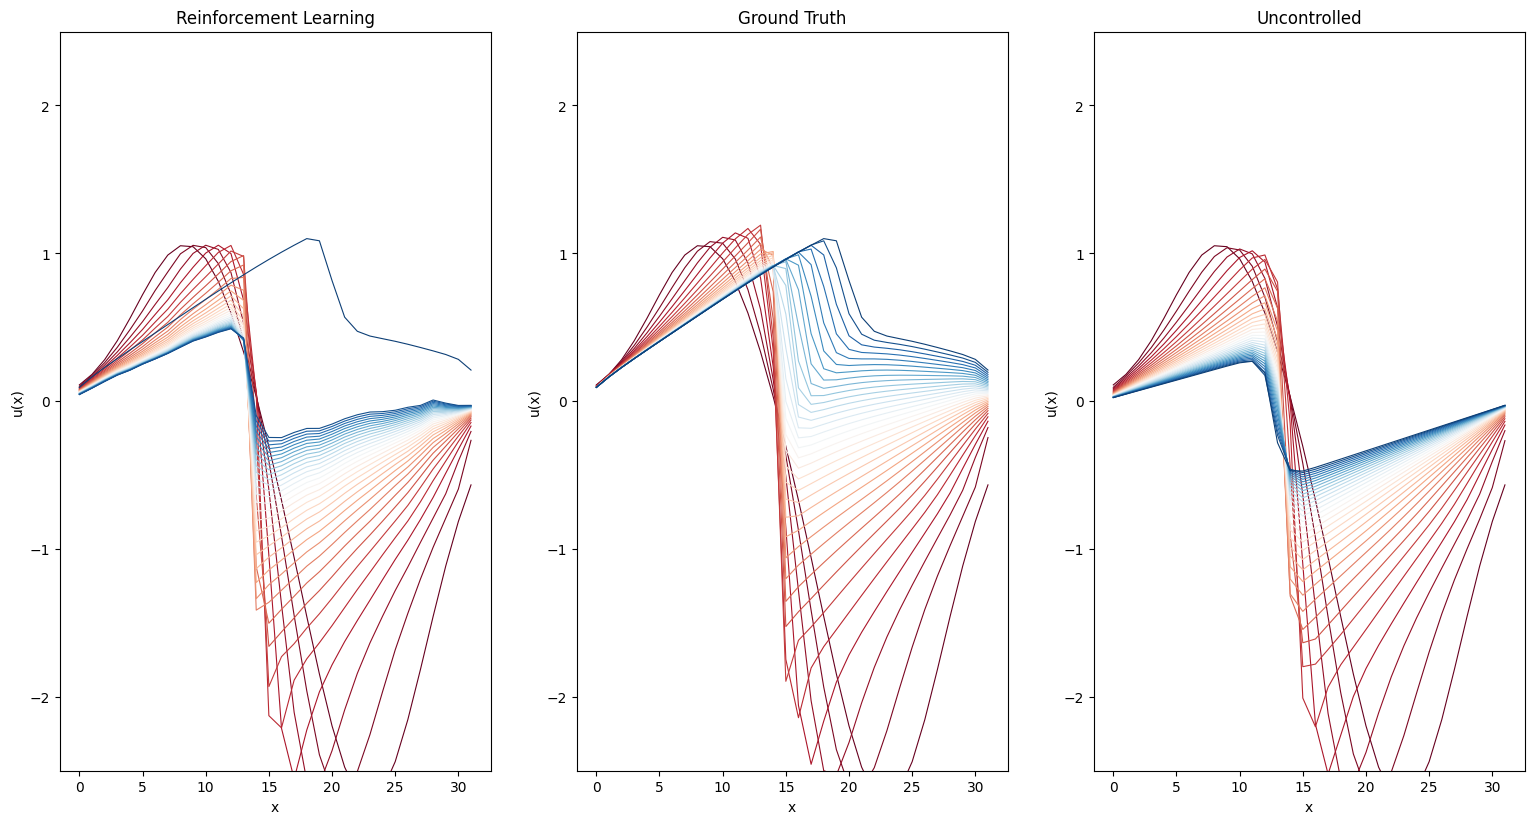

In [ ]:
TEST_SAMPLE = 0    # Change this to display a reconstruction of another scene
rl_frames, gt_frames, unc_frames = rl_trainer.infer_test_set_frames()

fig, axs = plt.subplots(1, 3, figsize=(18.9, 9.6))
axs[0].set_title("Reinforcement Learning"); axs[1].set_title("Ground Truth"); axs[2].set_title("Uncontrolled")
for plot in axs:
    plot.set_ylim(-2.5, 2.5); plot.set_xlabel('x'); plot.set_ylabel('u(x)')

for frame in range(0, STEP_COUNT + 1):
    frame_color = bplt.gradient_color(frame, STEP_COUNT+1);
    axs[0].plot(rl_frames[frame][TEST_SAMPLE,:], color=frame_color, linewidth=0.8)
    axs[1].plot(gt_frames[frame][TEST_SAMPLE,:], color=frame_color, linewidth=0.8)
    axs[2].plot(unc_frames[frame][TEST_SAMPLE,:], color=frame_color, linewidth=0.8)

As we can see, a trained reinforcement learning agent is able to reconstruct the trajectories fairly well. However, they still appear noticeably less smooth than the ground truth.

## Differentiable physics training

To classify the results of the reinforcement learning method, we now compare them to an approach using differentiable physics training. In contrast to the full approach from {doc}`diffphys-code-control` which includes a second _OP_ network, we aim for a direct control here. The OP network represents a separate "physics-predictor", which is omitted here for fairness when comparing with the RL version.

The DP approach has access to the gradient data provided by the differentiable solver, making it possible to trace the loss over multiple time steps and enabling the model to comprehend long term effects of generated forces better. The reinforcement learning algorithm, on the other hand, is not limited by training set size like the DP algorithm, as new training samples are generated on policy. However, this also introduces additional simulation overhead during training, which can increase the time needed for convergence. 

In [ ]:
from control.pde.burgers import BurgersPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence

Could not load resample cuda libraries: CUDA binaries not found at D:\Logiciels\Anaconda3\envs\RL\Lib\site-packages\phi\tf\cuda/build/resample.so. Run "python setup.py cuda" to compile them


D:\Logiciels\Anaconda3\envs\RL\lib\site-packages\phi\tf\__init__.py:7: UserWarning: TensorFlow 2 is not fully supported by PhiFlow.
  warnings.warn('TensorFlow 2 is not fully supported by PhiFlow.')
D:\Logiciels\Anaconda3\envs\RL\lib\site-packages\phi\tf\flow.py:15: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run\n$ python setup.py tf_cuda\nbefore reinstalling phiflow.")
D:\Drive\Etudes\Ponts et Chaussees\Stages\2eme stage\Travail\Physics based DL\code\PDE-Control/src\control\control_training.py:83: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if loss is not 0:


The cell below sets up a model for training or to load an existing model checkpoint.



In [ ]:
dp_app = ControlTraining(
    STEP_COUNT,
    BurgersPDE(DOMAIN, VISCOSITY, DT),
    datapath=DATA_PATH,
    val_range=VAL_RANGE,
    train_range=TRAIN_RANGE,
    trace_to_channel=lambda trace: 'burgers_velocity',
    obs_loss_frames=[],
    trainable_networks=['CFE'],
    sequence_class=StaggeredSequence,
    batch_size=100,
    view_size=20,
    learning_rate=1e-3,
    learning_rate_half_life=1000,
    dt=DT
).prepare()

App created. Scene directory is C:\Users\Theilo/phi/model/control-training\sim_000000 (INFO), 2023-02-24 16:53:16,820n

Sequence class: <class 'control.sequences.StaggeredSequence'> (INFO), 2023-02-24 16:53:16,869n

Partition length 32 sequence (from 0 to 32) at frame 16


D:\Logiciels\Anaconda3\envs\RL\lib\site-packages\phi\struct\context.py:18: UserWarning: struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.
  warnings.warn("struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.")
D:\Drive\Etudes\Ponts et Chaussees\Stages\2eme stage\Travail\Physics based DL\code\PDE-Control/src\control\pde\burgers.py:53: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  y = tf.layers.conv1d(
D:\Logiciels\Anaconda3\envs\RL\lib\site-packages\phi\tf\util.py:166: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  y = tf.layers.conv1d(y, nb_channels, kernel_size=kernel_size, strides=_strides, padding='valid',
D:\Logiciels\Anaconda3\envs\RL\lib\site-packages\phi\tf\util.py:172: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a f

Partition length 16 sequence (from 0 to 16) at frame 8
Partition length 8 sequence (from 0 to 8) at frame 4
Partition length 4 sequence (from 0 to 4) at frame 2
Partition length 2 sequence (from 0 to 2) at frame 1
Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3
Execute -> 3
Execute -> 4
Partition length 4 sequence (from 4 to 8) at frame 6
Partition length 2 sequence (from 4 to 6) at frame 5
Execute -> 5
Execute -> 6
Partition length 2 sequence (from 6 to 8) at frame 7
Execute -> 7
Execute -> 8
Partition length 8 sequence (from 8 to 16) at frame 12
Partition length 4 sequence (from 8 to 12) at frame 10
Partition length 2 sequence (from 8 to 10) at frame 9
Execute -> 9
Execute -> 10
Partition length 2 sequence (from 10 to 12) at frame 11
Execute -> 11
Execute -> 12
Partition length 4 sequence (from 12 to 16) at frame 14
Partition length 2 sequence (from 12 to 14) at frame 13
Execute -> 13
Execute -> 14
Partition length 2 sequence (from 14 to 16) at frame 15

Now we can execute the model training. This cell typically also takes a while to execute (ca. 2h for 1000 iterations).

In [ ]:
# DP_TRAINING_ITERATIONS = 1  # Change this to change training duration

# dp_training_eval_data = []
# start_time = time.time()

# for epoch in range(DP_TRAINING_ITERATIONS):
#     dp_app.progress()
#     # Evaluate validation set at regular intervals to track learning progress
#     # Size of intervals determined by RL epoch count per iteration for accurate comparison
#     if epoch % N_EPOCHS == 0:
#         f = dp_app.infer_scalars(VAL_RANGE)['Total Force'] / DT
#         dp_training_eval_data.append((time.time() - start_time, epoch, f))

Optimization (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 1288.0077, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 1032.7833 (INFO), 2023-02-24 17:06:24,968n

Validation (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 194.50278, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 300.62512 (INFO), 2023-02-24 17:07:28,916n



The trained model and the validation performance `val_forces.csv` with respect to iterations and wall time are saved on disk:



In [ ]:
# DP_STORE_PATH = 'networks/dp-models/bench'
# if not os.path.exists(DP_STORE_PATH):
#     os.makedirs(DP_STORE_PATH)

# # store training progress information
# with open(os.path.join(DP_STORE_PATH, 'val_forces.csv'), 'at') as log_file:
#     logger = csv.DictWriter(log_file, ('time', 'epoch', 'forces'))
#     logger.writeheader()
#     for (t, e, f) in dp_training_eval_data:
#         logger.writerow({'time': t, 'epoch': e, 'forces': f})

# dp_checkpoint = dp_app.save_model()
# shutil.move(dp_checkpoint, DP_STORE_PATH)

'networks/dp-models/bench\\checkpoint_00000001'

Alternatively, uncomment the code in the cell below to load an existing network model.


In [ ]:
dp_path = 'networks/dp-models/bench/checkpoint_00020000/'
networks_to_load = ['OP2', 'OP4', 'OP8', 'OP16', 'OP32']

dp_app.load_checkpoints({net: dp_path for net in networks_to_load})

Loading OP2 from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/... (INFO), 2023-02-24 17:10:36,231n

INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


Loading OP4 from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/... (INFO), 2023-02-24 17:10:39,952n

INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


Loading OP8 from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/... (INFO), 2023-02-24 17:10:43,342n

INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


Loading OP16 from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/... (INFO), 2023-02-24 17:10:46,701n

INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


Loading OP32 from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/... (INFO), 2023-02-24 17:10:49,965n

INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


INFO:tensorflow:Restoring parameters from PDE-Control-RL/networks/dp-models/bench/checkpoint_00020000/model.ckpt


Similar to the RL version, the next cell plots an example to visually show how well the DP-based model does. The leftmost plot again shows the learned results, this time of the DP-based model. Like above, the other two show the ground truth and the natural evolution. 

In [ ]:
dp_frames = dp_app.infer_all_frames(TEST_RANGE)
dp_frames = [s.burgers.velocity.data for s in dp_frames]
_, gt_frames, unc_frames = rl_trainer.infer_test_set_frames()

TEST_SAMPLE = 0    # Change this to display a reconstruction of another scene
fig, axs = plt.subplots(1, 3, figsize=(18.9, 9.6))

axs[0].set_title("Differentiable Physics")
axs[1].set_title("Ground Truth")
axs[2].set_title("Uncontrolled")

for plot in axs:
    plot.set_ylim(-2, 2)
    plot.set_xlabel('x')
    plot.set_ylabel('u(x)')

for frame in range(0, STEP_COUNT + 1):
    frame_color = bplt.gradient_color(frame, STEP_COUNT+1)
    axs[0].plot(dp_frames[frame][TEST_SAMPLE,:], color=frame_color, linewidth=0.8)
    axs[1].plot(gt_frames[frame][TEST_SAMPLE,:], color=frame_color, linewidth=0.8)
    axs[2].plot(unc_frames[frame][TEST_SAMPLE,:], color=frame_color, linewidth=0.8)

NameError: name 'dp_app' is not defined

The trained DP model also reconstructs the original trajectories closely. Furthermore, the generated results seem less noisy than using the RL agent.

With this, we have an RL and a DP version, which we can compare in more detail in the next section.

---


## Comparison between RL and DP

Next, the results of both methods are compared in terms of visual quality of the resulting trajectories as well as quantitatively via the amount of generated forces. The latter provides insights about the performance of either approaches as both methods aspire to minimize this metric during training. This is also important as the task is trivially solved by applying a huge force at the last time step. Therefore, an ideal solution takes into account the dynamics of the PDE to apply as little forces as possible. Hence, this metric is a very good one to measure how well the network has learned about the underlying physical environment (Burgers equation in this example).




In [ ]:
import utils
import pandas as pd

### Trajectory comparison

To compare the resulting trajectories, we generate trajectories from the test set with either method. Also, we collect the ground truth simulations and the natural evolution of the test set fields.



In [ ]:
rl_frames, gt_frames, unc_frames = rl_trainer.infer_test_set_frames()

dp_frames = dp_app.infer_all_frames(TEST_RANGE)
dp_frames = [s.burgers.velocity.data for s in dp_frames]

frames = {
    (0, 0): ('Ground Truth', gt_frames),
    (0, 1): ('Uncontrolled', unc_frames),
    (1, 0): ('Reinforcement Learning', rl_frames),
    (1, 1): ('Differentiable Physics', dp_frames),
}

NameError: name 'rl_trainer' is not defined

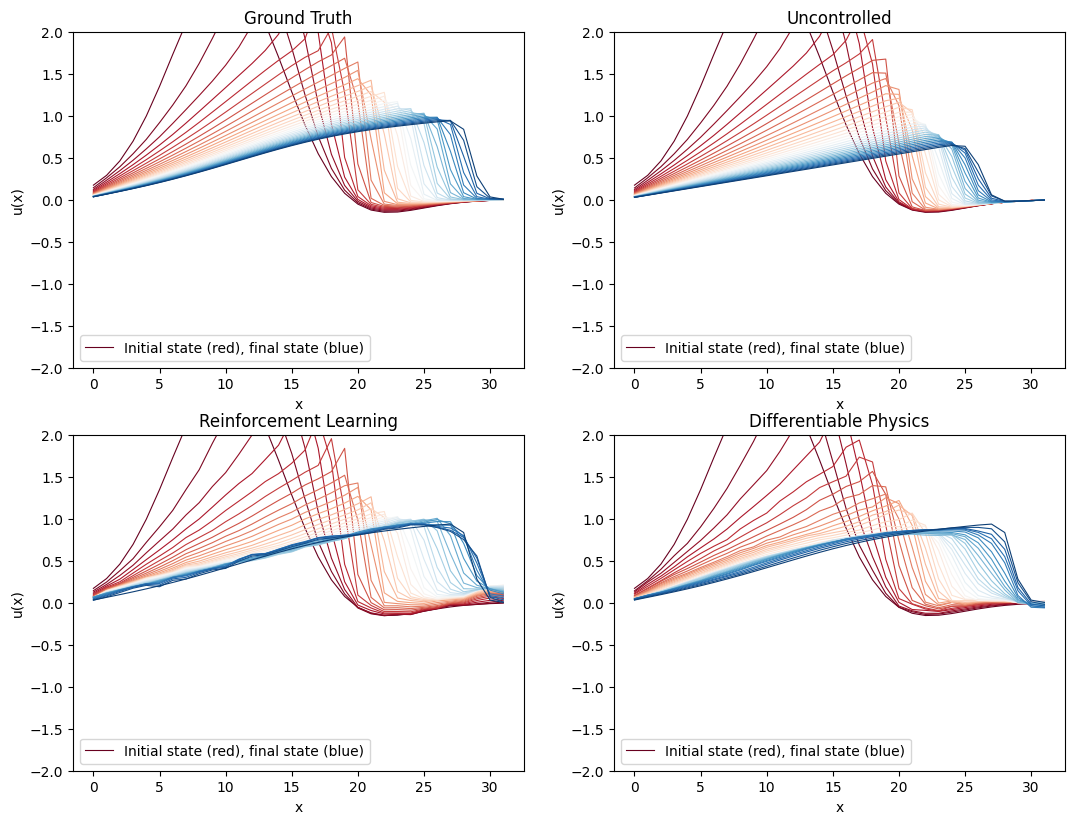

In [ ]:
TEST_SAMPLE = 0  # Specifies which sample of the test set should be displayed

def plot(axs, xy, title, field):
    axs[xy].set_ylim(-2, 2); axs[xy].set_title(title)
    axs[xy].set_xlabel('x'); axs[xy].set_ylabel('u(x)')
    label = 'Initial state (red), final state (blue)'
    for step_idx in range(0, STEP_COUNT + 1):
        color = bplt.gradient_color(step_idx, STEP_COUNT+1)
        axs[xy].plot(
            field[step_idx][TEST_SAMPLE].squeeze(), color=color, linewidth=0.8, label=label)
        label = None
    axs[xy].legend()

fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.6))
for xy in frames:
    plot(axs, xy, *frames[xy])

This diagram connects the two plots shown above after each training. Here we again see that the differentiable physics approach seems to generate less noisy trajectories than the RL agent, while both manage to approximate the ground truth.

### Comparison of exerted forces

Next, we compute the forces the approaches have generated and applied for the test set trajectories.

In [ ]:
gt_forces = utils.infer_forces_sum_from_frames(
    gt_frames, DOMAIN, DIFFUSION_SUBSTEPS, VISCOSITY, DT
)
dp_forces = utils.infer_forces_sum_from_frames(
    dp_frames, DOMAIN, DIFFUSION_SUBSTEPS, VISCOSITY, DT
)
rl_forces = rl_trainer.infer_test_set_forces()


Sanity check - maximum deviation from target state: 0.000000
Sanity check - maximum deviation from target state: 0.000000


At first, we will compare the total sum of the forces that are generated by the RL and DP approaches and compare them to the ground truth.

<BarContainer object of 3 artists>

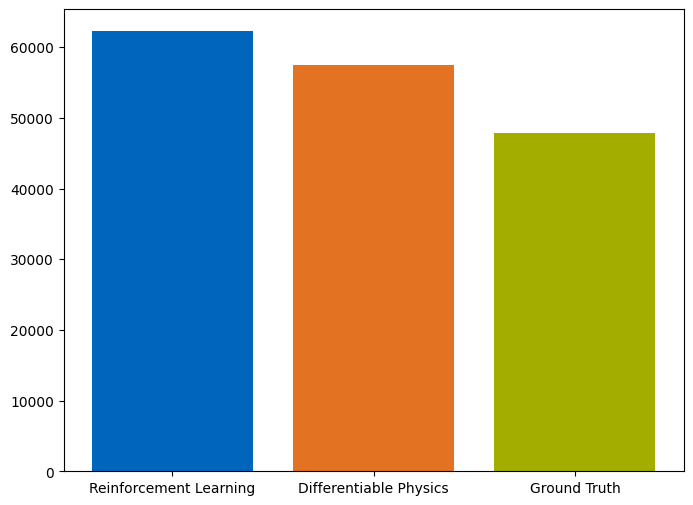

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(
    ["Reinforcement Learning", "Differentiable Physics", "Ground Truth"], 
    [np.sum(rl_forces), np.sum(dp_forces), np.sum(gt_forces)], 
    color = ["#0065bd", "#e37222", "#a2ad00"],
    align='center', label='Absolute forces comparison' )

As visualized in these bar plots, the DP approach learns to apply slightly lower forces than the RL model.
As both methods are on-par in terms of how well they reach the final target states, this is the main quantity we use to compare the performance of both methods.

In the following, the forces generated by the methods are also visually compared to the ground truth of the respective sample. Dots placed above the blue line denote stronger forces in the analyzed deep learning approach than in the ground truth and vice versa.


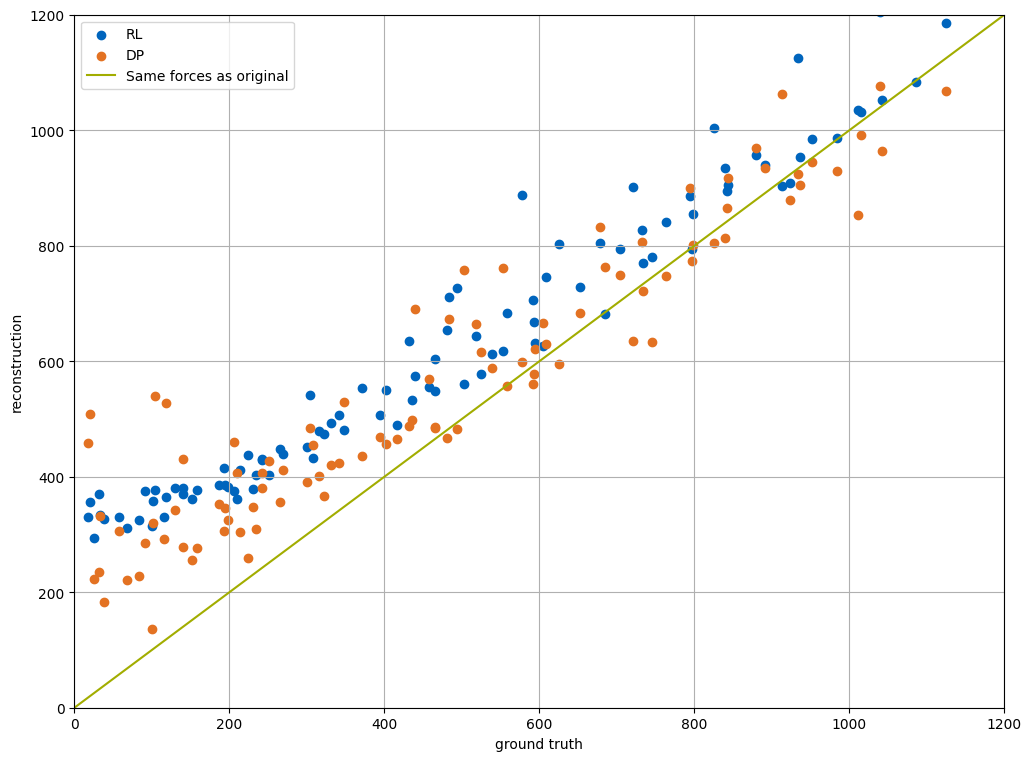

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(gt_forces, rl_forces, color="#0065bd", label='RL')
plt.scatter(gt_forces, dp_forces, color="#e37222", label='DP')
plt.plot([x * 100 for x in range(15)], [x * 100 for x in range(15)], color="#a2ad00", label='Same forces as original')
plt.xlabel('ground truth'); plt.ylabel('reconstruction')
plt.xlim(0, 1200); plt.ylim(0, 1200); plt.grid(); plt.legend()

The graph shows that the orange dots of the DP training run are in general closer to the diagonal - i.e., this network learned to generate forces that are closer to the ground truth values.

The following plot displays the performance of all reinforcement learning, differentiable physics and ground truth with respect to individual samples.

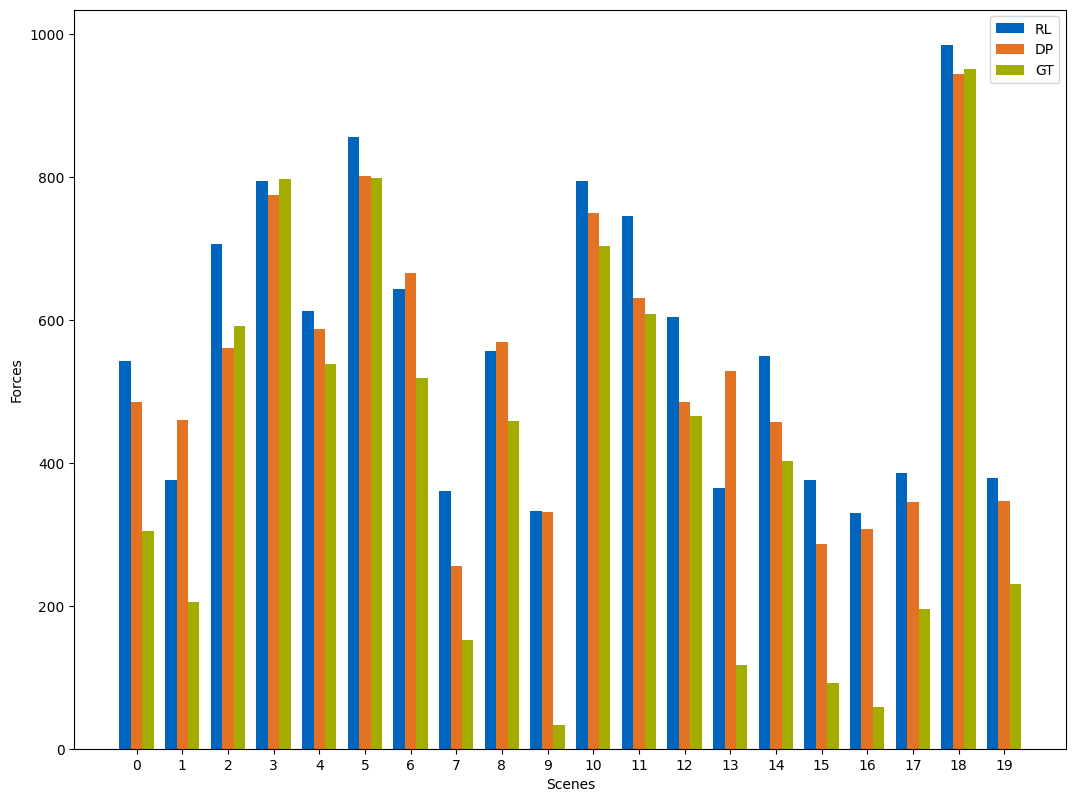

In [ ]:
w=0.25; plot_count=20   # How many scenes to show
plt.figure(figsize=(12.8, 9.6))
plt.bar( [i - w for i in range(plot_count)], rl_forces[:plot_count], color="#0065bd", width=w, align='center', label='RL' )
plt.bar( [i     for i in range(plot_count)], dp_forces[:plot_count], color="#e37222", width=w, align='center', label='DP' )
plt.bar( [i + w for i in range(plot_count)], gt_forces[:plot_count], color="#a2ad00", width=w, align='center', label='GT' )
plt.xlabel('Scenes'); plt.xticks(range(plot_count))
plt.ylabel('Forces'); plt.legend(); plt.show()

## Training progress comparison

Although the quality of the control in terms of force magnitudes is the primary goal of the setup above, there are interesting differences in terms of how both methods behave at training time. The main difference of the physics-unaware RL training and the DP approach with its tightly coupled solver is that the latter results in a significantly faster convergence. I.e., the gradients provided by the numerical solver give a much better learning signal than the undirected exploration of the RL process. The behavior of the RL training, on the other hand, can in part be ascribed to the on-policy nature of training data collection and to the "brute-force" exploration of the reinforcement learning technique.

The next cell visualizes the training progress of both methods with respect to wall time.



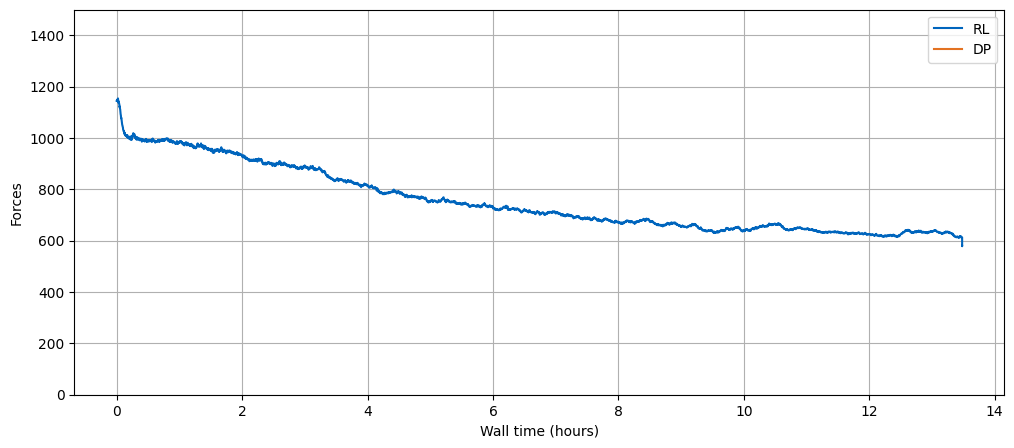

In [ ]:
def get_dp_val_set_forces(experiment_path):
    path = os.path.join(experiment_path, 'val_forces.csv')
    table = pd.read_csv(path)
    return list(table['time']), list(table['epoch']), list(table['forces'])

rl_w_times, rl_step_nums, rl_val_forces = rl_trainer.get_val_set_forces_data()
dp_w_times, dp_epochs, dp_val_forces = get_dp_val_set_forces(DP_STORE_PATH) 

plt.figure(figsize=(12, 5))
plt.plot(np.array(rl_w_times) / 3600, rl_val_forces, color="#0065bd", label='RL')
plt.plot(np.array(dp_w_times) / 3600, dp_val_forces, color="#e37222", label='DP')
plt.xlabel('Wall time (hours)'); plt.ylabel('Forces')
plt.ylim(0, 1500); plt.grid(); plt.legend()


To conclude, the PPO reinforcement learning exerts higher forces in comparison to the differentiable physics approach. Hence, PPO yields a learned solution with slightly inferior quality. Additionally, the time needed for convergence is significantly higher in the RL case (both in terms of wall time and training iterations). 



## Next steps

- See how different values for hyperparameters, such as learning rate, influence the training process

- Work with fields of different resolution and see how the two approaches then compare to each other. Larger resolutions make the physical dynamics more complex, and hence harder to control

- Use trained models in settings with different environment parameters (e.g. viscosity, dt) and test how well they generalize 

